# compareAtomicSimilarities

Given a set of proteins, some of which are heme binders and some of which are nucleotide binders, compare the histogram of atomic similarities (i.e. see what information we're losing with the averaging)

Steps:
- Read in the XYZ file for the protein and the labels
- Choose some of the proteins (see the work in sampling the full dataset)
- Run SOAPXX and get the kerns and perms matrices for REMATCH
- The overall score is `np.sum(kerns*perms)`. Look at what `kerns*perms` actually looks like. Is there a step?

In [1]:
import quippy
import ase
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib notebook

In [44]:
path_to_file = "/home/wpg23/rds/hpc-work/soapxxDir/sampledDataSet/output/samples.xyz"
atom_reader = quippy.AtomsReader(path_to_file, format="xyz")

In [19]:
# Get two heme binders, and two nucleotide binders
heme_samples = np.random.choice(range(100), size=2)
nucleotide_samples = np.random.choice(range(100,200), size=2)

In [31]:
heme_proteins = [atom_reader[i] for i in heme_samples]
print([x.params.get_value("tag") for x in heme_proteins])

nucleotide_proteins = [atom_reader[i] for i in nucleotide_samples]
print([x.params.get_value("tag") for x in nucleotide_proteins])

distinct_proteins = [atom_reader[heme_samples[0]],  atom_reader[nucleotide_samples[0]]]
print([x.params.get_value("tag")for x in distinct_proteins])


['4b4yA_heme', '1ft9A_heme']
['2g88A_nucleo', '5ve7A_nucleo']
['4b4yA_heme', '2g88A_nucleo']


Run SOAPXX, get the kerns and perms matrices required to calculate the REMATCH GLOSIM score

In [32]:
paths = ["hemes.xyz", "nucleos.xyz", "distincts.xyz"]
for path, samples in zip(paths, [heme_proteins, nucleotide_proteins, distinct_proteins]):
    out = quippy.io.AtomsWriter(path)
    for sample in samples:
        out.write(sample)
    out.close()

In [43]:
# The below doesn't work, for obscure linker reasons. 
# Run run.sh for each one in the terminal

# !source /home/wpg23/rds/hpc-work/soapxxDir/soapxx/soap/SOAPRC
# !echo $LD_LIBRARY_PATH

# for path in paths:
#     !./run.sh {path}

Double check that `P_base*K_base`, summed, gives the correct kernel

The overall score is `np.sum(kerns*perms)`. Look at what `kerns*perms` actually looks like. Is there a step?

In [71]:
nucleo_h5py = h5py.File("nucleos.xyz.hdf5", "r")
kernels = nucleo_h5py["kernel"]["kernel_mat"].value
nucleo_h5py.close()

In [72]:
kernels

array([[0.99927616, 0.77858424],
       [0.77858424, 0.9983156 ]], dtype=float32)

In [112]:
base_matrices_nucleos = [[{}, {}], [{}, {}]]
for i in [0,1]:
    for j in [0,1]:
        K_base_path = "nucleos/{0}_{1}_kerns.npy".format(i,j)
        K_base = np.load(K_base_path)
        P_base_path = "nucleos/{0}_{1}_perms.npy".format(i,j)
        P_base = np.load(P_base_path)
        print(np.sum(P_base*K_base))
        base_matrices_nucleos[i][j] = {"K_base": K_base, "P_base": P_base}

0.9992761609745849
0.7785842315044066
0.7785850246592896
0.9983155706201338


In [120]:
base_matrices_distinct = [[{}, {}], [{}, {}]]
for i in [0,1]:
    for j in [0,1]:
        K_base_path = "distincts/{0}_{1}_kerns.npy".format(i,j)
        K_base = np.load(K_base_path)
        P_base_path = "distincts/{0}_{1}_perms.npy".format(i,j)
        P_base = np.load(P_base_path)
        print(np.sum(P_base*K_base))
        base_matrices_distinct[i][j] = {"K_base": K_base, "P_base": P_base}



0.9982522219859333
0.7254981013847838
0.7254981013847838
0.9992761609745849


In [115]:
remade_kernel = []
for row in base_matrices_nucleos:
    kernel_row = []
    for col in row:
        K_base = col["K_base"]
        P_base = col["P_base"]
        kernel_row.append(np.sum(P_base*K_base))
    remade_kernel.append(kernel_row)


In [114]:
remade_kernel

[[0.9992761609745849, 0.7785842315044066],
 [0.7785850246592896, 0.9983155706201338]]

So the base matrices seem correct. K_base is the sum over all elements of the elementwise multiplication 
of K_Base and P_Base. I want the atom similarites

In [121]:
same_protein_similarities = base_matrices_nucleos[0][0]["K_base"]*base_matrices_nucleos[0][0]["P_base"]
different_protein_similarities_same_class = base_matrices_nucleos[0][1]["K_base"]*base_matrices_nucleos[0][1]["P_base"]
different_protein_similarities_different_class = base_matrices_distinct[0][1]["K_base"]*base_matrices_distinct[0][1]["P_base"]


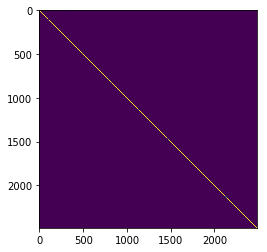

In [109]:
plt.imshow(same_protein_similarities)

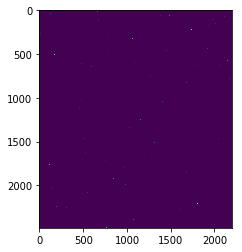

In [111]:
plt.imshow(different_protein_similarities_same_class)

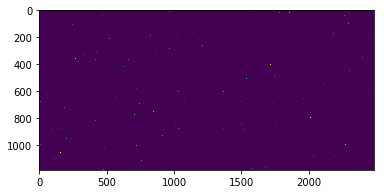

In [122]:
plt.imshow(different_protein_similarities_different_class)

I want a list of each  row's similarity, sorted, and plotted

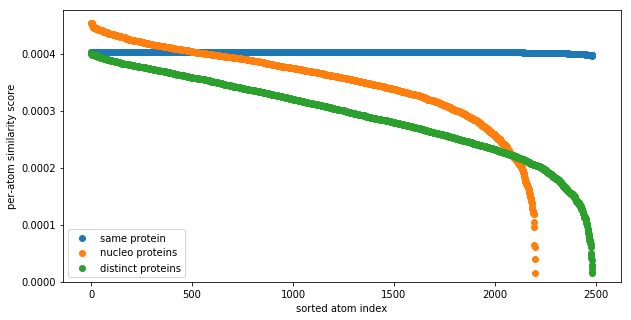

In [150]:
def plotSortedSimilarities(sim_matrix, ax=None, label=None):
    rowwise = np.sum(sim_matrix, axis=0)
    rowwise[::-1].sort()  # sort in reverse order
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(range(len(rowwise)), rowwise, label=label)
    plt.ylim(0, max(rowwise)*1.01)
    return ax
    
fig, ax = plt.subplots(figsize=(10,5))

plotSortedSimilarities(same_protein_similarities, ax=ax, label="same protein")

plotSortedSimilarities(different_protein_similarities_same_class, ax=ax, label="nucleo proteins")

plotSortedSimilarities(different_protein_similarities_different_class, ax=ax, label="distinct proteins")
plt.ylim(0, max(np.sum(different_protein_similarities_same_class, axis=0))*1.05)
plt.legend()
plt.ylabel("per-atom similarity score")
plt.xlabel("sorted atom index")
plt.savefig("atomic_similarities.png")
plt.show()


Is there a step? Maybe? It'd be more obvious if we normalised.

<IPython.core.display.Javascript object>


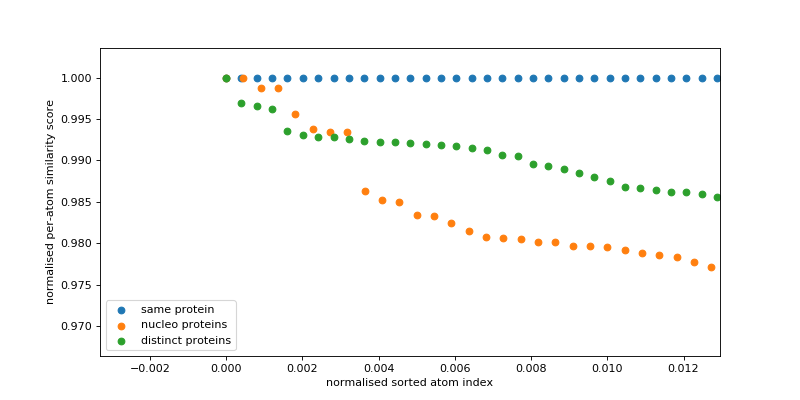

In [172]:
def plotSortedNormalisedSortedSimilarities(sim_matrix, ax=None, label=None):
    rowwise = np.sum(sim_matrix, axis=0)
    rowwise[::-1].sort()  # sort in reverse order
    
    rowwise /= max(rowwise)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(np.linspace(0,1, len(rowwise)), rowwise, label=label)
    plt.ylim(0, max(rowwise)*1.01)
    return ax
    
fig, ax = plt.subplots(figsize=(10,5))

plotSortedNormalisedSortedSimilarities(same_protein_similarities, ax=ax, label="same protein")

plotSortedNormalisedSortedSimilarities(different_protein_similarities_same_class, ax=ax, label="nucleo proteins")

plotSortedNormalisedSortedSimilarities(different_protein_similarities_different_class, ax=ax, label="distinct proteins")
plt.ylim(0, 1.05)

plt.legend()
plt.ylabel("normalised per-atom similarity score")
plt.xlabel("normalised sorted atom index")
plt.savefig("atomic_similarities.png")
plt.show()


## Listing the atoms that are the most similar in the proteins 

In [184]:
rowwise = np.sum(different_protein_similarities_same_class, axis=0)
rowwise[::-1].sort()  # sort in reverse order

rowwise /= rowwise[0]
print(rowwise)

[1.         0.99992958 0.99875893 ... 0.13257348 0.08651396 0.0347301 ]


In [195]:
rowwise = np.sum(different_protein_similarities_same_class, axis=0)
# Maybe I should use the flattened array, to get the mapping
indices = np.argsort(rowwise)

print(indices[:-10])  # Which atoms are these in the structure? We should find out

[1668 1669 2083 ...  916 2135 1293]


In [196]:
print(rowwise[indices[:-10]])

[1.57603225e-05 3.92595450e-05 6.01610940e-05 ... 4.46210381e-04
 4.46278530e-04 4.46951116e-04]


In [201]:
most_similar_atom_row = different_protein_similarities_same_class[indices[-1]]

In [203]:
sorted(most_similar_atom_row, reverse=True) 

[7.806526179130081e-05,
 7.638001864640831e-05,
 4.7451520660047015e-05,
 3.9153864198394394e-05,
 2.8612972059612463e-05,
 1.9653365258941914e-05,
 1.551061544031691e-05,
 1.2217813297858068e-05,
 1.069386958882348e-05,
 6.633342364734795e-06,
 6.108719656517495e-06,
 5.6816049689321074e-06,
 2.2330176341434665e-06,
 2.073392128121584e-06,
 1.7956103178534772e-06,
 1.7141084665157559e-06,
 1.4545367235837526e-06,
 1.4130421495597255e-06,
 1.3734319534026285e-06,
 1.2109526663841756e-06,
 8.905430802217481e-07,
 8.680180025945901e-07,
 6.443939641992639e-07,
 6.353561299894611e-07,
 3.7889632139925484e-07,
 3.646747488202242e-07,
 3.400304104608245e-07,
 2.916667190688455e-07,
 2.5048585245149763e-07,
 2.3819861590772226e-07,
 1.4311037753424473e-07,
 1.0638883255469733e-07,
 7.470764374223495e-08,
 6.542013046466119e-08,
 3.417628328937087e-08,
 1.7959895971585297e-08,
 1.261548257205746e-08,
 1.1964570634407784e-08,
 4.572423037912845e-09,
 3.053404626534655e-09,
 2.1827999917679965e

Irritatingly, this maps to a whole bunch of atoms in the target structure

In [214]:
# Check that axis=0 is the correct place to sum
first_protein = nucleotide_proteins[0]
print(first_protein.params)

tag=2g88A_nucleo


In [219]:
print(len(first_protein.arrays["positions"]))
print(len(np.sum(different_protein_similarities_same_class, axis=1)))

# So actually, axis=1 gives the similarity score for each atom in the first structure

2485
2485


In [231]:
# set the b-factor for the protein
def setBFactorAndOutputPDBFile(atomObject, similarities):
    """
    Given an Atoms object and the similarities for each atom, set the b-factor for the Atoms as the similarities then
    output the Atoms as a PDB for PyMoL viz (which I'll need to do locally)
    """
    assert len(atomObject.arrays["positions"] == len(similarities))
    atomObject.arrays["bfactor"] = similarities/max(similarities)
    return atomObject


In [232]:
atomObject = setBFactorAndOutputPDBFile(first_protein, np.sum(different_protein_similarities_same_class, axis=1))

In [233]:
out = quippy.AtomsWriter("temp.xyz")
out.write(atomObject)
out.close()
print(atomObject.arrays["bfactor"])

[0.91808381 0.35869176 0.91241913 ... 0.96207154 0.96219298 0.95869348]


In [234]:
ase.io.write("temp.pdb", atomObject, format="proteindatabank")

## One vs all

What I really need is to pick one protein at random, and get the similarities to all its friends.
Let's pick the first one, and run GLOSIM on everthing vs that one. (requires a custom kernel-compute.py)

In [235]:
nucleo_h5py = h5py.File("samples2.xyz.hdf5", "r")
kernels = nucleo_h5py["kernel"]["kernel_mat"].value
nucleo_h5py.close()

<IPython.core.display.Javascript object>


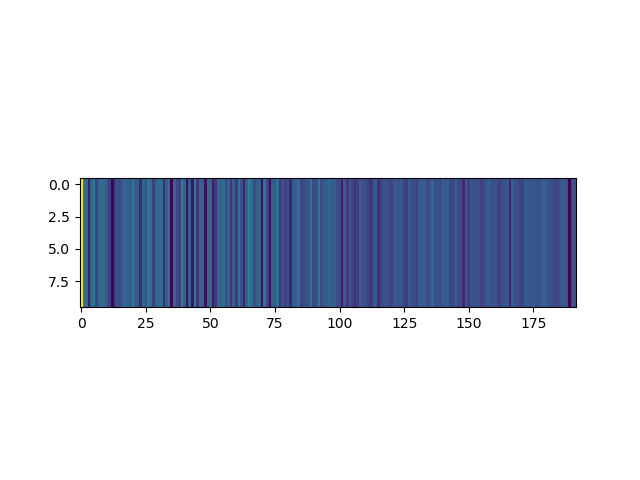

In [256]:
plt.imshow(np.vstack([kernels[:,0].T]*10), aspect=5)

<IPython.core.display.Javascript object>


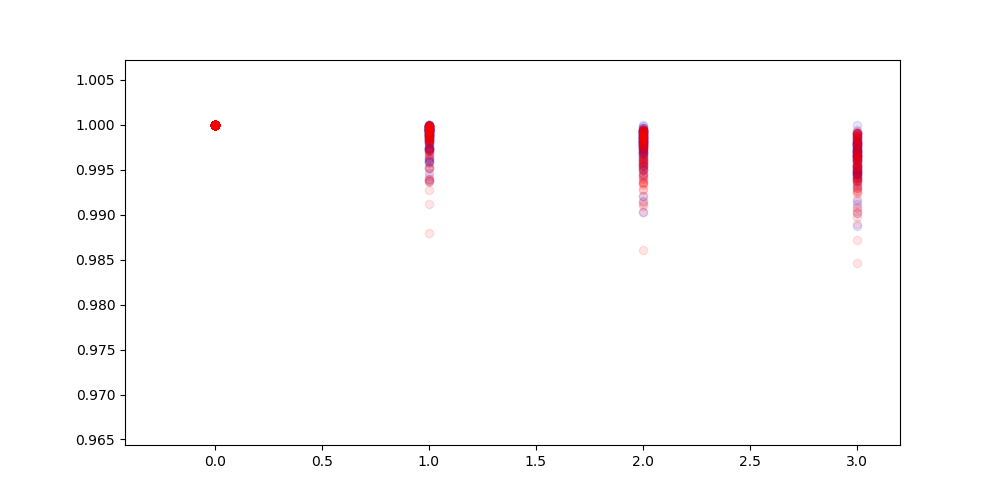

In [283]:
onevsall = h5py.File("samples2.xyz.hdf5", "r")

labels = onevsall["labels"]["label_mat"].value

def plotSortedSimilarities(sim_matrix, ax=None, colour=None, label=None):
    rowwise = np.sum(sim_matrix, axis=1)
    rowwise[::-1].sort()  # sort in reverse order
    rowwise /= max(rowwise)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(range(len(rowwise)), rowwise, label=label, c=colour, alpha=0.1)
    plt.ylim(0, max(rowwise)*1.05)
    return ax
    


fig, ax = plt.subplots(figsize=(10,5))

colours = ["blue", "red"]

for i, tag in enumerate(labels):
    kerns = np.load("onevsall_2/0_{}_kerns.npy".format(i))
    perms = np.load("onevsall_2/0_{}_perms.npy".format(i))
    atomic_similarity = kerns*perms
    
    tag = tag[1]
    if "heme" in tag:
        colour = colours[0]
    else:
        colour = colours[1]
    plotSortedSimilarities(atomic_similarity, ax=ax, colour=colour)

# plt.savefig("similarities_for_1h97A_heme.png", dpi=300)
plt.show()


In [286]:
# Can't tell what's going on. Plot the average and std for each class



# fig, ax = plt.subplots(figsize=(10,5))

# colours = ["blue", "red"]

hemes = []
nucleos = []



for i, tag in enumerate(labels):
    kerns = np.load("onevsall_2/0_{}_kerns.npy".format(i))
    perms = np.load("onevsall_2/0_{}_perms.npy".format(i))
    atomic_similarity = kerns*perms
    rowwise = np.sum(atomic_similarity, axis=1)
    rowwise[::-1].sort()  # sort in reverse order
    rowwise /= max(rowwise)
    tag = tag[1]
    if "heme" in tag:
        hemes.append(rowwise)
    else:
        nucleos.append(rowwise)

In [20]:
hemes = np.asarray(hemes)
nucleos = np.asarray(nucleos)

heme_means = np.mean(hemes, axis=1)
nucleo_means = np.mean(nucleos, axis=1)
heme_std = np.std(hemes, axis=1)
nucleo_std = np.std(nucleos, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(range(len(heme_means)), heme_means,label="hemes") #, yerr=heme_std) 
ax.errorbar(range(len(nucleo_means)), nucleo_means,label="nucleos")  #, yerr=nucleo_std)
plt.savefig("similarities_for_1h97A_heme_mean_.png", dpi=300)
plt.legend()

SyntaxError: invalid syntax (<ipython-input-20-4a221662686a>, line 12)

Is it always the same atom in the protein that's the most similar? How do the e.g top 10 most similar atoms compare?

SEA wants:
- a binding site for a particular ligand? (Is that not heme? Check 1h97A PDBe and the deepdrug3d paper)
- the comparison with residues
- Some obvious test, with a shared binding domain but structure differing outside
- All-to-all residue comparison

In [304]:
# Can't tell what's going on. Plot the average and std for each class



# fig, ax = plt.subplots(figsize=(10,5))

# colours = ["blue", "red"]

heme_indices = []
nucleo_indices = []



for i, tag in enumerate(labels):
    kerns = np.load("onevsall_2/0_{}_kerns.npy".format(i))
    perms = np.load("onevsall_2/0_{}_perms.npy".format(i))
    atomic_similarity = kerns*perms
    rowwise = np.sum(atomic_similarity, axis=1)
    indices = np.argsort(rowwise)
    if "heme" in tag[1]:
        heme_indices.append(indices)
    else:
        nucleo_indices.append(indices)

In [309]:
import collections
counter = collections.Counter()
for row in heme_indices:
    counter.update(row[-10:])
    

In [310]:
print(counter)

Counter({912: 62, 364: 60, 363: 55, 268: 48, 242: 43, 952: 42, 525: 35, 523: 34, 951: 33, 90: 31, 398: 27, 913: 25, 89: 23, 742: 19, 1117: 18, 840: 18, 166: 17, 977: 16, 136: 12, 223: 12, 808: 12, 758: 11, 809: 11, 165: 10, 181: 10, 706: 10, 628: 9, 637: 9, 254: 9, 267: 9, 935: 9, 948: 8, 444: 7, 161: 6, 1027: 5, 1043: 5, 705: 5, 892: 5, 950: 5, 482: 5, 555: 4, 556: 4, 583: 4, 195: 4, 255: 4, 807: 4, 838: 4, 947: 4, 99: 3, 126: 3, 164: 3, 799: 3, 839: 3, 1026: 2, 1072: 2, 436: 2, 588: 2, 98: 2, 1120: 2, 610: 2, 1124: 2, 160: 2, 679: 2, 206: 2, 252: 2, 286: 2, 301: 2, 829: 2, 324: 2, 347: 2, 889: 2, 900: 2, 1006: 2, 520: 1, 524: 1, 515: 1, 171: 1, 539: 1, 29: 1, 550: 1, 780: 1, 591: 1, 592: 1, 109: 1, 1141: 1, 1148: 1, 1151: 1, 134: 1, 194: 1, 659: 1, 682: 1, 683: 1, 174: 1, 687: 1, 708: 1, 203: 1, 721: 1, 722: 1, 740: 1, 244: 1, 251: 1, 765: 1, 266: 1, 789: 1, 304: 1, 320: 1, 833: 1, 835: 1, 334: 1, 851: 1, 352: 1, 870: 1, 359: 1, 373: 1, 896: 1, 832: 1, 798: 1, 934: 1, 447: 1, 965: 1,

In [315]:
for atom_index, number_of_occurrences in counter.most_common():
    print atom_index, number_of_occurrences

912 62
364 60
363 55
268 48
242 43
952 42
525 35
523 34
951 33
90 31
398 27
913 25
89 23
742 19
1117 18
840 18
166 17
977 16
136 12
223 12
808 12
758 11
809 11
165 10
181 10
706 10
628 9
637 9
254 9
267 9
935 9
948 8
444 7
161 6
1027 5
1043 5
705 5
892 5
950 5
482 5
555 4
556 4
583 4
195 4
255 4
807 4
838 4
947 4
99 3
126 3
164 3
799 3
839 3
1026 2
1072 2
436 2
588 2
98 2
1120 2
610 2
1124 2
160 2
679 2
206 2
252 2
286 2
301 2
829 2
324 2
347 2
889 2
900 2
1006 2
520 1
524 1
515 1
171 1
539 1
29 1
550 1
780 1
591 1
592 1
109 1
1141 1
1148 1
1151 1
134 1
194 1
659 1
682 1
683 1
174 1
687 1
708 1
203 1
721 1
722 1
740 1
244 1
251 1
765 1
266 1
789 1
304 1
320 1
833 1
835 1
334 1
851 1
352 1
870 1
359 1
373 1
896 1
832 1
798 1
934 1
447 1
965 1
968 1
463 1
468 1
481 1
485 1
766 1


In [384]:
path_to_file = "/home/wpg23/rds/hpc-work/soapxxDir/compareAtomicSimilarities/samples2.xyz"
atom_reader = quippy.AtomsReader(path_to_file, format="xyz")

In [385]:
# Check that axis=0 is the correct place to sum
first_protein = atom_reader[0]
atom_reader.close()
print(first_protein.params)

tag=1h97A_heme


In [390]:
# set the b-factor for the protein
def setBFactorAndOutputPDBFile(atomObject, similarities, pdbPath):
    """
    Given an Atoms object and the similarities for each atom, set the b-factor for the Atoms as the similarities then
    output the Atoms as a PDB for PyMoL viz (which I'll need to do locally)
    """
    assert len(atomObject.arrays["positions"] == len(similarities))
    atomObject.arrays["bfactor"] = np.asarray(similarities) # /max(similarities)
#     return atomObject
    ase.io.write(pdbPath, atomObject, format="proteindatabank")

In [391]:
similarities = np.zeros(len(first_protein.arrays["positions"]))
for index, count in counter.most_common():
    similarities[index] = count

In [394]:
setBFactorAndOutputPDBFile(first_protein, similarities, "1h97A_heme.pdb")

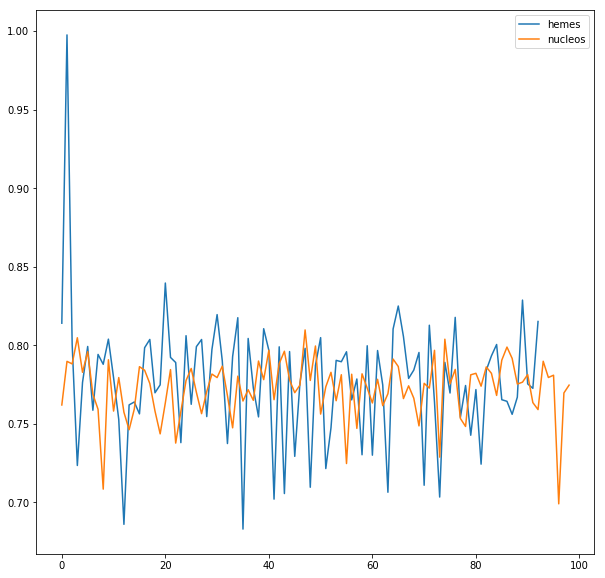

In [7]:
# Plot the average and std for each class, for the second protein

twovsall = h5py.File("twovsall/samples2.xyz.hdf5", "r")

labels = twovsall["labels"]["label_mat"].value


hemes = []
nucleos = []
heme_indices = []
nucleo_indices = []

for i, tag in enumerate(labels):
    kerns = np.load("twovsall/1_{}_kerns.npy".format(i))
    perms = np.load("twovsall/1_{}_perms.npy".format(i))
    atomic_similarity = kerns*perms
    rowwise = np.sum(atomic_similarity, axis=1)
    indices = np.argsort(rowwise)
    rowwise[::-1].sort()  # sort in reverse order
    rowwise /= max(rowwise)
    tag = tag[1]
    if "heme" in tag:
        hemes.append(rowwise)
        heme_indices.append(indices)

    else:
        nucleos.append(rowwise)
        nucleo_indices.append(indices)

        
hemes = np.asarray(hemes)
nucleos = np.asarray(nucleos)

heme_means = np.mean(hemes, axis=1)
nucleo_means = np.mean(nucleos, axis=1)
heme_std = np.std(hemes, axis=1)
nucleo_std = np.std(nucleos, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(range(len(heme_means)), heme_means,label="hemes") #, yerr=heme_std) 
ax.errorbar(range(len(nucleo_means)), nucleo_means,label="nucleos")  #, yerr=nucleo_std)
plt.savefig("similarities_for_2wtgA_heme_mean_.png", dpi=300)
plt.legend()

In [21]:
import collections
counter = collections.Counter()
for row in heme_indices:
    counter.update(row[-10:])
    

In [22]:
print(counter)

Counter({825: 52, 835: 49, 465: 47, 1274: 39, 1284: 38, 815: 37, 834: 27, 836: 27, 175: 26, 433: 26, 1062: 25, 406: 25, 489: 25, 498: 24, 609: 23, 1285: 23, 1238: 21, 445: 21, 856: 17, 512: 16, 645: 15, 824: 14, 751: 13, 701: 12, 864: 12, 881: 11, 1146: 10, 1275: 10, 21: 9, 1069: 9, 444: 9, 180: 8, 1070: 7, 1109: 7, 753: 7, 339: 7, 1107: 6, 956: 6, 1147: 6, 1273: 6, 813: 6, 452: 6, 463: 6, 497: 6, 521: 5, 205: 5, 717: 5, 296: 5, 865: 5, 354: 5, 487: 5, 1110: 4, 442: 4, 450: 4, 1112: 3, 648: 3, 996: 3, 488: 3, 584: 2, 92: 2, 1145: 2, 638: 2, 165: 2, 188: 2, 1258: 2, 1270: 2, 295: 2, 332: 2, 346: 2, 910: 2, 914: 2, 405: 2, 458: 2, 493: 2, 5: 1, 9: 1, 1060: 1, 52: 1, 1086: 1, 594: 1, 607: 1, 1162: 1, 654: 1, 655: 1, 1175: 1, 155: 1, 684: 1, 174: 1, 177: 1, 702: 1, 1237: 1, 217: 1, 731: 1, 227: 1, 977: 1, 1257: 1, 1268: 1, 780: 1, 303: 1, 1166: 1, 348: 1, 863: 1, 876: 1, 374: 1, 377: 1, 380: 1, 896: 1, 385: 1, 912: 1, 324: 1, 942: 1, 451: 1, 454: 1, 462: 1, 483: 1, 484: 1, 486: 1})


In [23]:
path_to_file = "/home/wpg23/rds/hpc-work/soapxxDir/compareAtomicSimilarities/samples2.xyz"
atom_reader = quippy.AtomsReader(path_to_file, format="xyz")
second_protein = atom_reader[1]
atom_reader.close()
print(second_protein.params)

tag=2wtgA_heme


In [24]:
# set the b-factor for the protein
def setBFactorAndOutputPDBFile(atomObject, similarities, pdbPath):
    """
    Given an Atoms object and the similarities for each atom, set the b-factor for the Atoms as the similarities then
    output the Atoms as a PDB for PyMoL viz (which I'll need to do locally)
    """
    assert len(atomObject.arrays["positions"] == len(similarities))
    atomObject.arrays["bfactor"] = np.asarray(similarities) # /max(similarities)
#     return atomObject
    ase.io.write(pdbPath, atomObject, format="proteindatabank")

In [25]:
similarities = np.zeros(len(second_protein.arrays["positions"]))
for index, count in counter.most_common():
    similarities[index] = count

In [28]:
setBFactorAndOutputPDBFile(second_protein, similarities, "2wtgA_heme.pdb")

In [30]:
max(second_protein.arrays["bfactor"])

52.0

In [31]:
!ls .

0_0_kerns.npy	  25_81_kerns.npy
0_0_perms.npy	  25_81_perms.npy
0_100_kerns.npy   25_82_kerns.npy
0_100_perms.npy   25_82_perms.npy
0_101_kerns.npy   25_83_kerns.npy
0_101_perms.npy   25_83_perms.npy
0_102_kerns.npy   25_84_kerns.npy
0_102_perms.npy   25_84_perms.npy
0_103_kerns.npy   25_85_kerns.npy
0_103_perms.npy   25_85_perms.npy
0_104_kerns.npy   25_86_kerns.npy
0_104_perms.npy   25_86_perms.npy
0_105_kerns.npy   25_87_kerns.npy
0_105_perms.npy   25_87_perms.npy
0_106_kerns.npy   25_88_kerns.npy
0_106_perms.npy   25_88_perms.npy
0_107_kerns.npy   25_89_kerns.npy
0_107_perms.npy   25_89_perms.npy
0_108_kerns.npy   2_58_kerns.npy
0_108_perms.npy   2_58_perms.npy
0_109_kerns.npy   25_90_kerns.npy
0_109_perms.npy   25_90_perms.npy
0_10_kerns.npy	  25_91_kerns.npy
0_10_perms.npy	  25_91_perms.npy
0_110_kerns.npy   25_92_kerns.npy
0_110_perms.npy   25_92_perms.npy
0_111_kerns.npy   25_93_kerns.npy
0_111_perms.npy   25_93_perms.npy
0_112_kerns.npy   25_94_kerns.npy
0_112_perms.npy   25_9

12_35_perms.npy   32_121_kerns.npy
12_36_kerns.npy   32_121_perms.npy
12_36_perms.npy   32_122_kerns.npy
12_37_kerns.npy   32_122_perms.npy
12_37_perms.npy   32_123_kerns.npy
12_38_kerns.npy   32_123_perms.npy
12_38_perms.npy   32_124_kerns.npy
12_39_kerns.npy   32_124_perms.npy
12_39_perms.npy   32_125_kerns.npy
1_23_kerns.npy	  32_125_perms.npy
1_23_perms.npy	  32_126_kerns.npy
12_40_kerns.npy   32_126_perms.npy
12_40_perms.npy   32_127_kerns.npy
12_41_kerns.npy   32_127_perms.npy
12_41_perms.npy   32_128_kerns.npy
12_42_kerns.npy   32_128_perms.npy
12_42_perms.npy   32_129_kerns.npy
12_43_kerns.npy   32_129_perms.npy
12_43_perms.npy   32_130_kerns.npy
12_44_kerns.npy   32_130_perms.npy
12_44_perms.npy   32_131_kerns.npy
12_45_kerns.npy   32_131_perms.npy
12_45_perms.npy   32_132_kerns.npy
12_46_kerns.npy   32_132_perms.npy
12_46_perms.npy   32_133_kerns.npy
12_47_kerns.npy   32_133_perms.npy
12_47_perms.npy   32_134_kerns.npy
12_48_kerns.npy   32_134_perms.npy
12_48_perms.npy   32_1

(2, '1tu9A_heme')


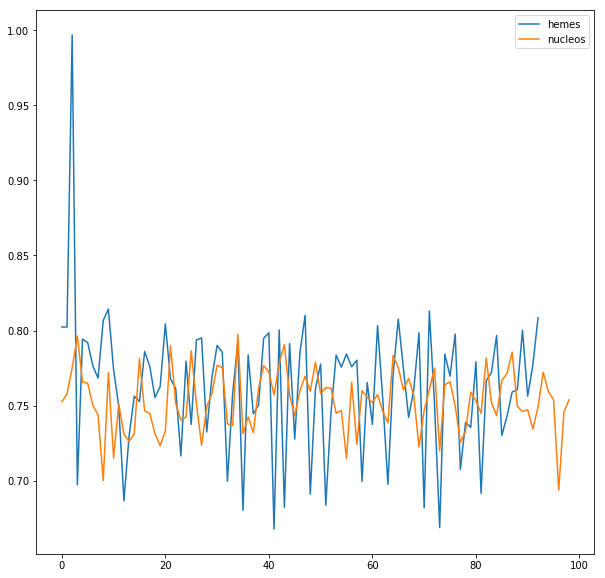

In [36]:
# Plot the average and std for each class, for the third protein

threevsall = h5py.File("allvsall2/samples2.xyz.hdf5", "r")

labels = threevsall["labels"]["label_mat"].value
print(labels[2])


hemes = []
nucleos = []
heme_indices = []
nucleo_indices = []

for i, tag in enumerate(labels):
    if i < 2:
        kerns = np.load("allvsall2/{}_2_kerns.npy".format(i))
        perms = np.load("allvsall2/{}_2_perms.npy".format(i))
    else:
        kerns = np.load("allvsall2/2_{}_kerns.npy".format(i))
        perms = np.load("allvsall2/2_{}_perms.npy".format(i))
    atomic_similarity = kerns*perms
    rowwise = np.sum(atomic_similarity, axis=1)
    indices = np.argsort(rowwise)
    rowwise[::-1].sort()  # sort in reverse order
    rowwise /= max(rowwise)
    tag = tag[1]
    if "heme" in tag:
        hemes.append(rowwise)
        heme_indices.append(indices)

    else:
        nucleos.append(rowwise)
        nucleo_indices.append(indices)

        
hemes = np.asarray(hemes)
nucleos = np.asarray(nucleos)

heme_means = np.mean(hemes, axis=1)
nucleo_means = np.mean(nucleos, axis=1)
heme_std = np.std(hemes, axis=1)
nucleo_std = np.std(nucleos, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(range(len(heme_means)), heme_means,label="hemes") #, yerr=heme_std) 
ax.errorbar(range(len(nucleo_means)), nucleo_means,label="nucleos")  #, yerr=nucleo_std)
# plt.savefig("similarities_for_2wtgA_heme_mean_.png", dpi=300)
plt.legend()
plt.show()


In [38]:
import collections
counter = collections.Counter()
for row in heme_indices:
    counter.update(row[-10:])
    

In [40]:
path_to_file = "/home/wpg23/rds/hpc-work/soapxxDir/compareAtomicSimilarities/allvsall2/samples2.xyz"
atom_reader = quippy.AtomsReader(path_to_file, format="xyz")
third_protein = atom_reader[2]
atom_reader.close()
print(third_protein.params)

similarities = np.zeros(len(third_protein.arrays["positions"]))
for index, count in counter.most_common():
    similarities[index] = count

tag=1tu9A_heme


In [ ]:
setBFactorAndOutputPDBFile(third_protein, similarities, "1tu9A_heme.pdb")

In [ ]:
# Plot the average and std for each class, for the third protein
def generatePDBfile(index):
    dataFile = h5py.File("allvsall2/samples2.xyz.hdf5", "r")
    labels = dataFile["labels"]["label_mat"].value
    label = labels[index][1]
    # Get atomic similarity differences between the two classes
    hemes = []
    nucleos = []
    heme_indices = []
    nucleo_indices = []
    for i, tag in enumerate(labels):
        if i < index:
            kerns = np.load("allvsall2/{0}_{1}_kerns.npy".format(i, index))
            perms = np.load("allvsall2/{0}_{1}_perms.npy".format(i, index))
        else:
            kerns = np.load("allvsall2/{1}_{0}_kerns.npy".format(i, index))
            perms = np.load("allvsall2/{1}_{0}_perms.npy".format(i, index))
        atomic_similarity = kerns*perms
        rowwise = np.sum(atomic_similarity, axis=1)
        indices = np.argsort(rowwise)
        rowwise[::-1].sort()  # sort in reverse order
        rowwise /= max(rowwise)
        tag = tag[1]
        if "heme" in tag:
            hemes.append(rowwise)
            heme_indices.append(indices)
        else:
            nucleos.append(rowwise)
            nucleo_indices.append(indices)
    hemes = np.asarray(hemes)
    nucleos = np.asarray(nucleos)

    heme_means = np.mean(hemes, axis=1)
    nucleo_means = np.mean(nucleos, axis=1)
    heme_std = np.std(hemes, axis=1)
    nucleo_std = np.std(nucleos, axis=1)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.errorbar(range(len(heme_means)), heme_means,label="hemes")
    ax.errorbar(range(len(nucleo_means)), nucleo_means,label="nucleos")
    plt.legend()
    plt.show()

    counter = collections.Counter()
    for row in heme_indices:
        counter.update(row[-10:])

    path_to_file = "/home/wpg23/rds/hpc-work/soapxxDir/compareAtomicSimilarities/allvsall2/samples2.xyz"
    atom_reader = quippy.AtomsReader(path_to_file, format="xyz")
    protein = atom_reader[index]
    atom_reader.close()
    print(protein.params)

    similarities = np.zeros(len(protein.arrays["positions"]))
    for index, count in counter.most_common():
        similarities[index] = count

    setBFactorAndOutputPDBFile(protein, similarities, "{}.pdb".format(label))
    
    

### Strategy

The above is dumb. What I should do is:

- Get the similarity between the test protein and all the proteins in the training set.
- Sum over the atoms in the training proteins, so you're left with a vector of length (number of atoms in the test protein), giving the similarity between those atoms and the atoms in the training protein. NORMALISE? You'll have one of those for each protein in the training set.
- Average over all training proteins. Compare the results of the heme set to the nucleotide set, spot a difference. 

In [149]:
# Plot the average and std for each class, for the third protein
def generatePDBfileGivingAverageSimilarity(index):
    dataFile = h5py.File("allvsall2/samples2.xyz.hdf5", "r")
    labels = dataFile["labels"]["label_mat"].value
    label = labels[index][1]
    
    # Get atomic similarity differences between the two classes
    hemes = []
    nucleos = []
    
    for i, tag in enumerate(labels):
        if i < index:
            kerns = np.load("allvsall2/{0}_{1}_kerns.npy".format(i, index)).T
            perms = np.load("allvsall2/{0}_{1}_perms.npy".format(i, index)).T
        else:
            kerns = np.load("allvsall2/{1}_{0}_kerns.npy".format(i, index))
            perms = np.load("allvsall2/{1}_{0}_perms.npy".format(i, index))
        atomic_similarity = kerns*perms
        # The similarity between each atom of the test protein and the target protein 
        atomic_similarity = np.sum(atomic_similarity, axis=1)
        # Normalise so the total similarity is 1
        atomic_similarity /= np.sum(atomic_similarity)
        
        tag = tag[1]
        if "heme" in tag:
            hemes.append(atomic_similarity)
        else:
            nucleos.append(atomic_similarity)

    hemes = np.asarray(hemes)
    nucleos = np.asarray(nucleos)
    
    heme_means = np.mean(hemes, axis=0)
    nucleo_means = np.mean(nucleos, axis=0)
        
    path_to_file = "/home/wpg23/rds/hpc-work/soapxxDir/compareAtomicSimilarities/allvsall2/samples2.xyz"
    atom_reader = quippy.AtomsReader(path_to_file, format="xyz")
    protein = atom_reader[index]
    atom_reader.close()
    print(protein.params)

    assert len(heme_means) == len(protein.arrays["positions"])
    assert len(nucleo_means) == len(protein.arrays["positions"])

    # I want to highlight the most similar atoms. So zero out the atoms which have similarity less than the top-20 value.
    top20_threshold = sorted(heme_means)[-20]
    for i, x in enumerate(heme_means):
        if x < top20_threshold:
            heme_means[i] = 0

    top20_threshold = sorted(nucleo_means)[-20]
    for i, x in enumerate(nucleo_means):
        if x < top20_threshold:
            nucleo_means[i] = 0

            
    
    # Multiple by 1000, as otherwise the b-factors round out
    setBFactorAndOutputPDBFile(protein, heme_means*1000, "averageSim/{}_vshemes.pdb".format(label))
    setBFactorAndOutputPDBFile(protein, nucleo_means*1000, "averageSim/{}_vsnucleos.pdb".format(label))
    
    

In [150]:
for i in range(20):
    generatePDBfileGivingAverageSimilarity(i)

tag=1h97A_heme
tag=2wtgA_heme
tag=1tu9A_heme
tag=2uydA_heme
tag=1cpqA_heme
tag=1x9fG_heme
tag=5y8aA_heme
tag=4u99A_heme
tag=1allA_heme
tag=1b8dA_heme
tag=3oa8B_heme
tag=2ybqA_heme
tag=4lmxC_heme
tag=4gd3I_heme
tag=1yq4D_heme
tag=1ft9A_heme
tag=4g1xA_heme
tag=4rm4A_heme
tag=4xxlA_heme
tag=4eieA_heme
